# Leap Frog Time Stepping for Yang Mills

See work of Christiansen, Winther
https://epubs.siam.org/doi/pdf/10.1137/040616887

Srinath Bulusu, Joachim Schöberl

In [1]:
from ngsolve import *

from ngsolve.meshes import *

from ngsolve.solvers import *
from ngsolve.webgui import Draw

import matplotlib.pyplot as plt

from su2_yangmills import *

import numpy as np
import json

Setting some parameters in the simulation
including the folders name for saving results

In [2]:
parameters = {}
parameters["h"] = 0.025
#parameters["h"] = 0.05
parameters["n"] = int(1/parameters["h"])
parameters["order"] = 3
parameters["dt"] = 0.001

#figfolder_name = f"n{parameters['n']}_order{parameters['order']}_dt{parameters['dt']}"  
figfolder_name = f"abelian_mixed_n{parameters['n']}_order{parameters['order']}_dt{parameters['dt']}"  
if not os.path.exists(figfolder_name):
    os.makedirs(figfolder_name)

Mesh generation with periodic boundary conditions

In [3]:
ne=parameters["n"]
#mesh = MakeStructured2DMesh(quads=False, nx=ne, ny=ne, periodic_x=True, periodic_y=True)
mesh = MakeStructured2DMesh(quads=True, nx=ne, ny=ne, periodic_x=True, periodic_y=True)
#mesh = MakeStructured2DMesh(quads=False, nx=ne, ny=ne, periodic_x=False, periodic_y=False)

Draw(mesh)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

Finite Element Spaces
su(2)-valued functions are represented by three dimensional (non-spatial!!!) vectors

In [4]:
order=parameters["order"]

# Would be in the regular 3D case
#fesC = H1(mesh)**3 # for su2 charge
#fesA = HCurl(mesh)**3 # for su2 gauge potential

# spaces for z splitted functions
#fesC = Periodic(H1(mesh, order=order))**3 # for su2 charge
#fesC = Periodic(L2(mesh, order=order))**3 # for su2 charge
fesC = Periodic(L2(mesh, order=order-1))**3 # for su2 charge
fesA = Periodic(HCurl(mesh, order=order))**3 # for su2 gauge potential
fesAz = Periodic(H1(mesh, order=order))**3 # for su2 gauge potential z component

fesA3D = fesA*fesAz

fesA3DC = fesA3D*fesC

Creating Trial and Test Function for assembly of forms

In [5]:
A, Az = fesA3D.TrialFunction()
E, Ez = fesA3D.TrialFunction()
B, Bz = fesA3D.TrialFunction()

Ap, Azp = fesA3D.TestFunction()
Ep, Ezp = fesA3D.TestFunction()
Bp, Bzp = fesA3D.TestFunction()

#A3D = fesA3D.TrialFunction()
#E3D = fesA3D.TrialFunction()
#B3D = fesA3D.TrialFunction()

#A3D = fesA3D.TestFunction()
#E3Dp = fesA3D.TestFunction()
#B3Dp = fesA3D.TestFunction()

C = fesC.TrialFunction()
Cp = fesC.TestFunction()


gfA3D = GridFunction(fesA3D)
gfE3D = GridFunction(fesA3D)
gfC = GridFunction(fesC)

gfB3D = GridFunction(fesA3D)

gfP = GridFunction(fesC)

gfEdotP = GridFunction(fesA3DC)


# no spatial current present in this scenario
#gfJ3D = GridFunction(fesA3D)
#gfJ3D.Set((0,0,0 ,0,0,0 ,0,0,0))

#gfJ = GridFunction(fesA)
#J_gf.Set((0,0 ,0,0 ,0,0))
#gfJz = GridFunction(fesAz)
#Jz_gf.Set((0 ,0 ,0))

Forms used in time stepping of simulation

In [6]:
# matrices for E-A leapfrog time stepping
m = BilinearForm(fesA3D)
m += LieInnerProduct(E,Ep)*dx
m += LieInnerProduct(Ez,Ezp)*dx
#m += LieInnerProduct(E3D,E3Dp)*dx

m.Assemble()
minv = m.mat.Inverse(fesA3D.FreeDofs(), inverse="sparsecholesky")

covdiv_F = BilinearForm(fesA3D, nonassemble=True)
curl_A_2Dz_CF = curl_A_2Dz(A, Az, Ep, Ezp)
F_A_2Dz_CF = F_A_2Dz(A, Az)
covdiv_F += InnerProduct(F_A_2Dz_CF, curl_A_2Dz_CF)*dx(bonus_intorder=2*order)

covdiv = BilinearForm(fesA3D, nonassemble=True)
curl_A_Ep_CF = curl_A_2Dz(gfA3D.components[0], gfA3D.components[1], Ep, Ezp)
# TODO: B in Hdiv?
covdiv += InnerProduct(gVector_3DCF(B,Bz), curl_A_Ep_CF)*dx(bonus_intorder=order)

covgrad = BilinearForm(trialspace=fesC, testspace=fesA3D, nonassemble=True)
grad_A_2Dz_C_CF = grad_A_2Dz(gfA3D.components[0], gfA3D.components[1], C)
covgrad += InnerProduct(grad_A_2Dz_C_CF, gVector_3DCF(Ep,Ezp))*dx(bonus_intorder=order)


curv = BilinearForm(fesA3D, nonassemble=True)
F_A_2Dz_CF = F_A_2Dz(A, Az)
curv += InnerProduct(F_A_2Dz_CF, gVector_3DCF(Bp, Bzp))*dx(bonus_intorder=order)



f = LinearForm(fesA3D)
#f += InnerProduct(J_gf, Ep)*dx
#f += InnerProduct(Jz_gf, Ezp)*dx
f.Assemble()

Forms for evaluating the charge a posteriori

In [7]:
# matrices for evaluating charge
mC = BilinearForm(fesC)
mC += LieInnerProduct(C,Cp)*dx

mC.Assemble()
mCinv = mC.mat.Inverse(fesC.FreeDofs(), inverse="sparsecholesky")


covdivC = BilinearForm(trialspace=fesA3D, testspace=fesC, nonassemble=True)
grad_A_2Dz_Cp_CF = grad_A_2Dz(gfA3D.components[0], gfA3D.components[1], Cp)
covdivC += LieInnerProduct(gVector_3DCF(E,Ez), grad_A_2Dz_Cp_CF)*dx(bonus_intorder=order)

Setting the initial conditions for E and A for two spatially separated flux tubes
Applying a su(2)-gauge transformation parametrized by scalar "angle" phi and "rotation axis" n (in quaternion space)
The Coefficientfunctions are interpolated into FEM spaces

In [9]:
# initial conditions

sigma2 = 0.003
mu1 = [0.7, 0.5]
mu2 = [0.3, 0.5]
mu3 = [0.5, 0.3]

E_init_CF = CF( (0,0 ,0,0 ,0,0) ).Reshape((3,2))
#Ez_init_CF = CF( (gaussxyper(mu1, sigma2) ,gaussxyper(mu2, sigma2) ,0) ).Reshape((3,1))

Ez_init_CF = CF( (gaussxyper(mu1, sigma2) + gaussxyper(mu2, sigma2) , gaussxyper(mu1, sigma2) + gaussxyper(mu2, sigma2) ,0) ).Reshape((3,1))

A_init_CF = CF( (0,0 ,0,0 ,0,0) ).Reshape((3,2))
Az_init_CF = CF( (0 ,0 ,0) ).Reshape((3,1))


# gauge transformations
# phi*n_k is are the Lie Algebra coefficients in the same basis as E,A ([.,.] becomes Cross!)
#phi_CF = CF( 0.25*pi )

r = lambda mu: [(x-mu[0]),(y-mu[1])]
# create gauge transformations that are 0 at border and therefore periodic
bubble = lambda mu: 16*(r(mu)[0]+0.5)*(r(mu)[0]+0.5-1)*(r(mu)[1]+0.5)*(r(mu)[1]+0.5-1)
#bubble = lambda mu: 16*(r(mu)[0]-0.5)*(r(mu)[0]-0.5-1)*(r(mu)[1]-0.5)*(r(mu)[1]-0.5-1)


phi_CF = lambda mu: CF( 0 )

phi_CF = bubble([0.5,0.5])*phi_CF([0.5, 0.5])
#phi_CF = phi_CF(mu1)


Draw(phi_CF, mesh)


#n_CF = CF( (0.01,(x-0.5), (y-0.5)) )
#norm_n = Norm(n_CF)
#if Integrate(sqrt(norm_n*norm_n), mesh) < 0.001:
#    norm_n += 0.001   
#n_CF = 1/norm_n * n_CF
n_CF = CF( (0,0,1) )

# gauge the fields according to appropriate transformation behaviour

# adjoint representation
E_gauged_CF = gauge_1f(E_init_CF, phi_CF, n_CF)
Ez_gauged_CF = gauge_0f(Ez_init_CF, phi_CF, n_CF)

#gAginv should remain 0 ...
# the dz(g) ginv term is missing due to z symmetry
A_gauged_CF = gauge_A(A_init_CF, phi_CF, n_CF)
Az_gauged_CF = gauge_0f(Az_init_CF, phi_CF, n_CF)

gfA3D.components[0].Set(A_gauged_CF)
gfA3D.components[1].Set(Az_gauged_CF)

gfE3D.components[0].Set(E_gauged_CF)
gfE3D.components[1].Set(Ez_gauged_CF)


#the norm in Lie Algebra space should be invariant under gauges!
gauge_Ez_dict = {"ungauged Ez conf:": (Ez_init_CF, {}), "gauged Ez conf:": (Ez_gauged_CF, {})}
#generate_scenes(gauge_Ez_dict, mesh=mesh)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

In [10]:
# A_dict = {"Ax": (gfA3D.components[0][:,0], {}),
#           "Ay": (gfA3D.components[0][:,1], {}),
#           "Az": (gfA3D.components[1], {})
#          }

# E_dict = {"Ex": (gfE3D.components[0][:,0], {}),
#           "Ey": (gfE3D.components[0][:,1], {}),
#           "Ez": (gfE3D.components[1], {})
#          }

#generate_scenes(A_dict, mesh=mesh)
#generate_scenes(E_dict, mesh=mesh)

Function to evaluate the charge at a timestep

In [11]:
def calc_charge(gfE3D, gfC, temp_div_A_E, covdivC=covdivC):
    temp_div_A_E[:] = 0.
    covdivC.Apply(gfE3D.vec, temp_div_A_E)
    gfC.vec.data = mCinv * temp_div_A_E
    return gfC

#calculate initial charge
gfC0 = GridFunction(fesC)
temp_div_A_E0 = gfC0.vec.CreateVector()
calc_charge(gfE3D, gfC0, temp_div_A_E0)
#Draw (gfC0[:], mesh )

Functions to evaluate the energies

In [12]:
temp_div_A_F = gfA3D.vec.CreateVector()
gfdiv_A_F = GridFunction(fesA3D)
temp_div_A_F[:] = 0.

def calc_B3D(gfA3D, gfB3D):
    curv.Apply(gfA3D.vec, temp_div_A_F)
    gfB3D.vec.data = minv * temp_div_A_F

def calc_energies(gfA3D, gfE3D, gfB3D, gfH_dict=None):
    to_return = False
    if gfH_dict == None:
        gfH_dict = {"HEL": None, "HET": None, "HBL": None, "HBT": None}
        to_return = True
    #gfH_dict = {"HEL": None, "HET": None}
    
    gfHET = LieInnerProduct(gfE3D.components[0], gfE3D.components[0])
    gfHEL = LieInnerProduct(gfE3D.components[1], gfE3D.components[1])

    # if gfB3D==None:
    #     gfB3D = GridFunction(fesA3D)
    
    calc_B3D(gfA3D, gfB3D)
        
    gfHBT = LieInnerProduct(gfB3D.components[0], gfB3D.components[0])
    gfHBL = LieInnerProduct(gfB3D.components[1], gfB3D.components[1])
    
    gfH_dict["HET"] = gfHET
    gfH_dict["HEL"] = gfHEL
    gfH_dict["HBT"] = gfHBT
    gfH_dict["HBL"] = gfHBL

    if to_return == True:
        return gfH_dict

#gfH0_dict = calc_energies(gfA3D, gfE3D)
#Draw(gfH0_dict['HEL'], mesh)

Define length of simulation

In [13]:
# 2. is good for visuals
#tend = 2.
#tend = 1.00
# 0.6 is good for visuals
tend = 0.6
#tend = 0.5
#tend = 0.3
#dt = 0.00001
dt = parameters["dt"]
t = 0.
n_steps = int(tend/dt)
print(n_steps)

600


the time stepping loop including evaluation and tracking of observables

In [14]:
temp_div_A_F = gfA3D.vec.CreateVector()
gfdiv_A_F = GridFunction(fesA3D)
temp_div_A_F[:] = 0.

temp_div_A_E = gfC.vec.CreateVector()
temp_div_A_E[:] = 0.

    
def time_step(gfA3D, gfE3D, temp_div_A_F, covdiv_F=covdiv_F):
    temp_div_A_F[:] = 0.
    # A update
    gfA3D.vec.data -= dt * gfE3D.vec
    
    # E update
    covdiv_F.Apply(gfA3D.vec, temp_div_A_F)
    #temp_div_A_F += f.vec
    gfE3D.vec.data += dt * minv * temp_div_A_F


q =[]
dq2 =[]
H = {"HEL": [], "HET": [], "HBL": [], "HBT": []}


gfH_dict = calc_energies(gfA3D, gfE3D, gfB3D)
#calc_energies(gfA3D, gfE3D, gfB3D)


draw_kwargs = {"autoscale":False, "min":0, "max":2000}


scenes_dict = {}
scenes_dict["C"] = (gfC, {})

scenes_dict["A"] = (gfA3D.components[0], {})
scenes_dict["Az"] = (gfA3D.components[1], {})

calc_B3D(gfA3D, gfB3D)
scenes_dict["B"] = (gfB3D.components[0], {})
scenes_dict["Bz"] = (gfB3D.components[1], {})

scenes_dict["E"] = (gfE3D.components[0], {})
#scenes_dict["Ez"] = (gfE3D.components[1], draw_kwargs)
scenes_dict["Ez"] = (gfE3D.components[1], {})

for energy_name in gfH_dict:
    scenes_dict[energy_name] = (gfH_dict[energy_name], {})


snap_names = [name for name in scenes_dict.keys()]
snap_gfs = [scenes_dict[name][0] for name in scenes_dict.keys()]
#nt_snaps = list(range(0,n_steps,int(n_steps/10)))

viz_steps = 10

nt_snaps = [ i*int(n_steps/viz_steps) for i in range(viz_steps) ]
#nt_snaps = list(range(0,n_steps,int(n_steps/viz_steps)))
#nt_snaps = list(range(0,n_steps,int(n_steps)))
#nt_snaps = [0, 10, 20]

if not os.path.exists(f"{figfolder_name}/vtk"):
    os.makedirs(f"{figfolder_name}/vtk")
vtk = VTKOutput(mesh, coefs=snap_gfs, names=snap_names,filename=f"{figfolder_name}/vtk/vtk_snap",subdivision=2)
vtk.Do(time=0)
        
scenes = generate_scenes(scenes_dict=scenes_dict, mesh=mesh)
#scenes = []



# visualize with trace-visualizer vite
# https://docu.ngsolve.org/latest/i-tutorials/unit-1.9-taskmanager/taskmanager.html
with TaskManager(): # paketrace=10**8):
    for n in range(n_steps):
        #timestep
        #time_step(gfA3D, gfE3D)
        time_step(gfA3D, gfE3D, temp_div_A_F)

        if (n >= 0):
            #solve for charge
            q_diff = Norm(calc_charge(gfE3D, gfC, temp_div_A_E)) - Norm(gfC0)
            q.append(Integrate(q_diff, mesh))
            dq2.append(Integrate(q_diff*q_diff, mesh) - Integrate(q_diff, mesh)**2)
            
            
        if (n >= 0):
            #gfH_dict = calc_energies(gfA3D, gfE3D, gfB3D=None, gfH_dict=gfH_dict)
            calc_B3D(gfA3D, gfB3D)
            calc_energies(gfA3D, gfE3D, gfB3D=gfB3D, gfH_dict=gfH_dict)
            
            for energy_name in gfH_dict:
                
                #TODO: integrate over 2 dimensions
                _H = Integrate(gfH_dict[energy_name], mesh)
                H[energy_name].append(_H)

        if (n in nt_snaps):
            current_snaps = {}
            for snap_name in snap_names:
                #pass
                # save vtk snapshots
                vtk.Do(time=n*dt)
            #vtk.Do(time=t)

        #vtk.Do(time=n*dt)
                
        #input()
        t += dt
        #if n % 100 == 0:
        if n % 10 == 0:
            for scene in scenes:
                #pass
                scene.Redraw()
            print ("\r", t, end="")
print("\nsimulation done\n")

C


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

A


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Az


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

B


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Bz


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

E


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Ez


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

HEL


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

HET


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

HBL


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

HBT


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…



 0.591000000000000473
simulation done



In [15]:
vtk.Do(time=t)

'abelian_mixed_n40_order3_dt0.001/vtk/vtk_snap_step00111'

In [16]:
#plt.plot(range(0,len(dq)),dq)
plt.loglog(range(0,len(q)),q, label="C")
plt.loglog(range(0,len(dq2)),dq2, label=r"$\Delta C^2$")
plt.legend()

q_plot_filename = f"C_n{ne}_dt{dt}_order{order}_timstep"

plt.savefig(f"{figfolder_name}/{q_plot_filename}.png")

with open(f"{figfolder_name}/{q_plot_filename}.json", "w") as f:
    json.dump(q, f, indent=2)

dq2_plot_filename = f"dq2_n{ne}_dt{dt}_order{order}_timstep"

#plt.savefig(f"{figfolder_name}/{dq2_plot_filename}.png")

with open(f"{figfolder_name}/{dq2_plot_filename}.json", "w") as f:
    json.dump(dq2, f, indent=2)
    
plt.close()

HEL
HET
HBL
HBT
HEL
HET
HBL
HBT


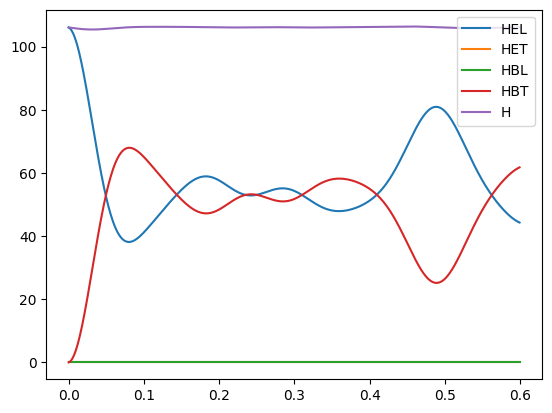

In [17]:
for energy_name in H:
    print(energy_name)
    ts = [ float(i) * dt for i in range(0,len(H[energy_name])) ]
    #plt.plot(range(0,len(H[energy_name])),H[energy_name], label=energy_name)
    plt.plot(ts,H[energy_name], label=energy_name)


sumH = np.sum([H[e] for e in H.keys()], axis=0)

#plt.plot(range(0,len(H[energy_name])),sumH, label="H")
plt.plot(ts,sumH, label="H")
plt.legend()
plt.savefig(f"{figfolder_name}/H2Dz_n{ne}_dt{dt}_order{order}timestep.png")


H_plot_filename = f"_n{ne}_dt{dt}_order{order}_timstep"

for energy_name in H:
    print(energy_name)
    with open(f"{figfolder_name}/{energy_name}{H_plot_filename}.json", "w") as f:
        json.dump(H[energy_name], f, indent=2)
        
with open(f"{figfolder_name}/H{H_plot_filename}.json", "w") as f:
    json.dump(list(sumH), f, indent=2)

plt.show()
plt.close()

In [18]:
figfolder_name

'abelian_mixed_n40_order3_dt0.001'

In [19]:
len(nt_snaps)

10